In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_data = pd.read_csv('Dataset.txt', sep='\t')
test_data = pd.read_csv('Dataset_test.txt', sep='\t')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Training data columns: {train_data.columns.tolist()}")

# Check target variable distribution
print("\nTarget variable distribution:")
print(train_data['C'].value_counts())
print(train_data['C'].value_counts(normalize=True))

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum().sum())

Training data shape: (101180, 24)
Test data shape: (19913, 23)
Training data columns: ['Index', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'C']

Target variable distribution:
C
0    76353
1    24827
Name: count, dtype: int64
C
0    0.754625
1    0.245375
Name: proportion, dtype: float64

Missing values in training data:
0

Missing values in test data:
0


Training data description:
               Index             F1             F2             F3  \
count  101180.000000  101180.000000  101180.000000  101180.000000   
mean    50590.500000       0.502348       0.501497       0.499886   
std     29208.294456       0.288058       0.289017       0.288875   
min         1.000000       0.000018       0.000004       0.000002   
25%     25295.750000       0.253819       0.251115       0.248818   
50%     50590.500000       0.501802       0.501095       0.499820   
75%     75885.250000       0.753598       0.752404       0.750281   
max    101180.000000       0.999986       0.999990       0.999985   

                  F4             F5             F6             F7  \
count  101180.000000  101180.000000  101180.000000  101180.000000   
mean        0.499839     -29.742617       1.511000       7.939118   
std         0.288729    5781.829379    5796.594007    5765.581875   
min         0.000006  -10000.000000  -10000.000000  -10000.000000   
25%   

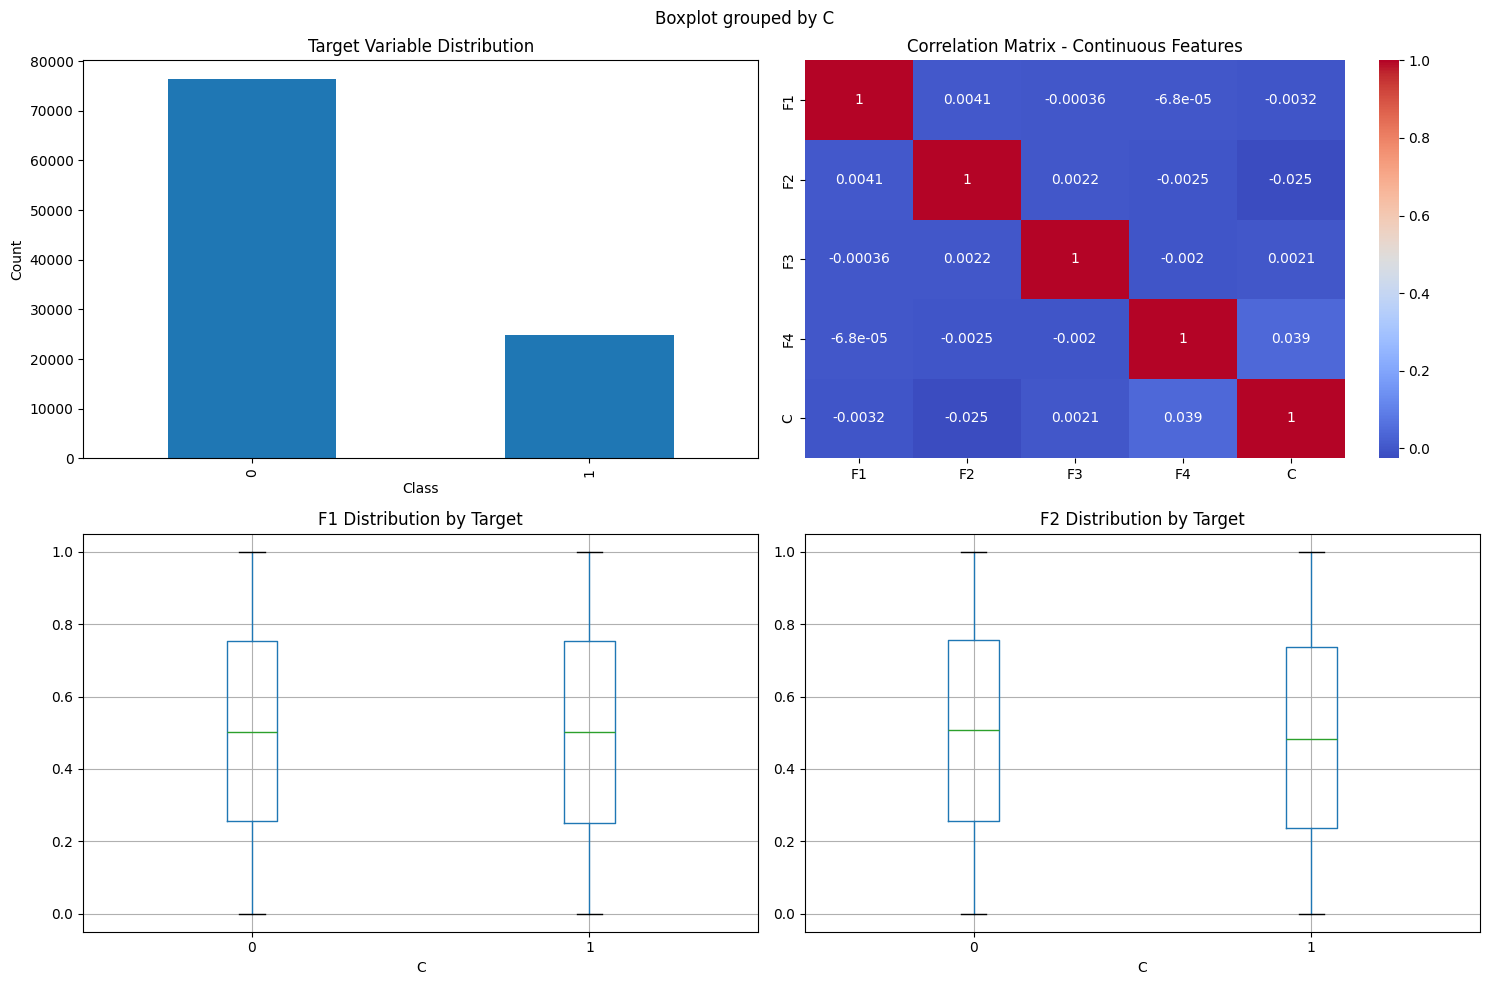

In [3]:
# Basic statistics
print("Training data description:")
print(train_data.describe())

# Feature categorization
continuous_features = ['F1', 'F2', 'F3', 'F4']  # Appear to be normalized (0-1)
integer_features = ['F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14']
date_features = ['F15', 'F16']  # Date strings
categorical_features = ['F17', 'F18']  # Small integers (categories)
aggregate_features = ['F19', 'F20', 'F21', 'F22']  # Possibly counts/aggregates

print(f"Continuous features: {len(continuous_features)}")
print(f"Integer features: {len(integer_features)}")
print(f"Date features: {len(date_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Aggregate features: {len(aggregate_features)}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target distribution
train_data['C'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Target Variable Distribution')
axes[0,0].set_xlabel('Class')
axes[0,0].set_ylabel('Count')

# Correlation matrix for continuous features
corr_matrix = train_data[continuous_features + ['C']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[0,1])
axes[0,1].set_title('Correlation Matrix - Continuous Features')

# Box plots for continuous features by target
train_data.boxplot(column='F1', by='C', ax=axes[1,0])
axes[1,0].set_title('F1 Distribution by Target')

train_data.boxplot(column='F2', by='C', ax=axes[1,1])
axes[1,1].set_title('F2 Distribution by Target')

plt.tight_layout()
plt.show()

In [4]:
from datetime import datetime

def engineer_features(data, is_training=True):
    """Feature engineering function"""
    data_processed = data.copy()
    
    # 1. Date feature engineering
    for date_col in date_features:
        # Convert to datetime
        data_processed[date_col] = pd.to_datetime(data_processed[date_col], errors='coerce')
        
        # Extract components
        data_processed[f'{date_col}_year'] = data_processed[date_col].dt.year
        data_processed[f'{date_col}_month'] = data_processed[date_col].dt.month
        data_processed[f'{date_col}_day'] = data_processed[date_col].dt.day
        
        # Days since epoch (for temporal ordering)
        data_processed[f'{date_col}_days_since_epoch'] = (
            data_processed[date_col] - pd.Timestamp('1970-01-01')
        ).dt.days
    
    # Calculate date difference (F16 - F15)
    if len(date_features) >= 2:
        data_processed['date_diff_days'] = (
            data_processed[date_features[1]] - data_processed[date_features[0]]
        ).dt.days
    
    # Handle missing values in derived date features
    date_derived_cols = []
    for date_col in date_features:
        date_derived_cols.extend([
            f'{date_col}_year', f'{date_col}_month', f'{date_col}_day', 
            f'{date_col}_days_since_epoch'
        ])
    if len(date_features) >= 2:
        date_derived_cols.append('date_diff_days')
    
    for col in date_derived_cols:
        if col in data_processed.columns:
            data_processed[col] = data_processed[col].fillna(data_processed[col].median())
    
    # Remove original date columns and index
    columns_to_drop = date_features + (['Index'] if is_training else ['Index'])
    data_processed = data_processed.drop(columns=columns_to_drop)
    
    return data_processed, date_derived_cols

# Apply feature engineering
train_processed, date_derived_cols = engineer_features(train_data, is_training=True)
test_processed, _ = engineer_features(test_data, is_training=False)

# Define final feature columns
feature_columns = [col for col in train_processed.columns if col != 'C']

print(f"Original features: {len([col for col in train_data.columns if col not in ['Index', 'C']])}")
print(f"Features after engineering: {len(feature_columns)}")
print(f"New date-derived features: {date_derived_cols}")

Original features: 22
Features after engineering: 29
New date-derived features: ['F15_year', 'F15_month', 'F15_day', 'F15_days_since_epoch', 'F16_year', 'F16_month', 'F16_day', 'F16_days_since_epoch', 'date_diff_days']


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb

# Prepare features and target
X = train_processed[feature_columns]
y = train_processed['C']

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Initialize models and results storage
models = {}
scaler = StandardScaler()

# 1. Logistic Regression (requires scaling)
print("\n1. Training Logistic Regression...")
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_val_scaled)
lr_pred_proba = lr.predict_proba(X_val_scaled)[:, 1]

models['Logistic Regression'] = {
    'model': lr,
    'accuracy': accuracy_score(y_val, lr_pred),
    'auc': roc_auc_score(y_val, lr_pred_proba),
    'predictions': lr_pred,
    'probabilities': lr_pred_proba,
    'scaled': True
}

# 2. Random Forest (works with original features)
print("\n2. Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_pred_proba = rf.predict_proba(X_val)[:, 1]

models['Random Forest'] = {
    'model': rf,
    'accuracy': accuracy_score(y_val, rf_pred),
    'auc': roc_auc_score(y_val, rf_pred_proba),
    'predictions': rf_pred,
    'probabilities': rf_pred_proba,
    'feature_importance': rf.feature_importances_,
    'scaled': False
}

# 3. XGBoost
print("\n3. Training XGBoost...")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

models['XGBoost'] = {
    'model': xgb_model,
    'accuracy': accuracy_score(y_val, xgb_pred),
    'auc': roc_auc_score(y_val, xgb_pred_proba),
    'predictions': xgb_pred,
    'probabilities': xgb_pred_proba,
    'feature_importance': xgb_model.feature_importances_,
    'scaled': False
}

# Model comparison
print("\n4. Model Performance Comparison:")
print("-" * 50)
print(f"{'Model':<20} {'Accuracy':<10} {'AUC':<10}")
print("-" * 50)

best_model_name = max(models.keys(), key=lambda k: models[k]['auc'])

for model_name, model_info in models.items():
    accuracy = model_info['accuracy']
    auc = model_info['auc']
    print(f"{model_name:<20} {accuracy:<10.4f} {auc:<10.4f}")

print("-" * 50)

# Detailed evaluation of best model
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print("Classification Report:")
print(classification_report(y_val, best_model['predictions']))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, best_model['predictions'])
print(cm)

Training set: (80944, 29)
Validation set: (20236, 29)

1. Training Logistic Regression...

2. Training Random Forest...

3. Training XGBoost...

4. Model Performance Comparison:
--------------------------------------------------
Model                Accuracy   AUC       
--------------------------------------------------
Logistic Regression  0.7546     0.6857    
Random Forest        0.7527     0.6916    
XGBoost              0.7513     0.7034    
--------------------------------------------------

Best Model: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.96      0.85     15271
           1       0.47      0.12      0.19      4965

    accuracy                           0.75     20236
   macro avg       0.62      0.54      0.52     20236
weighted avg       0.70      0.75      0.69     20236

Confusion Matrix:
[[14611   660]
 [ 4372   593]]


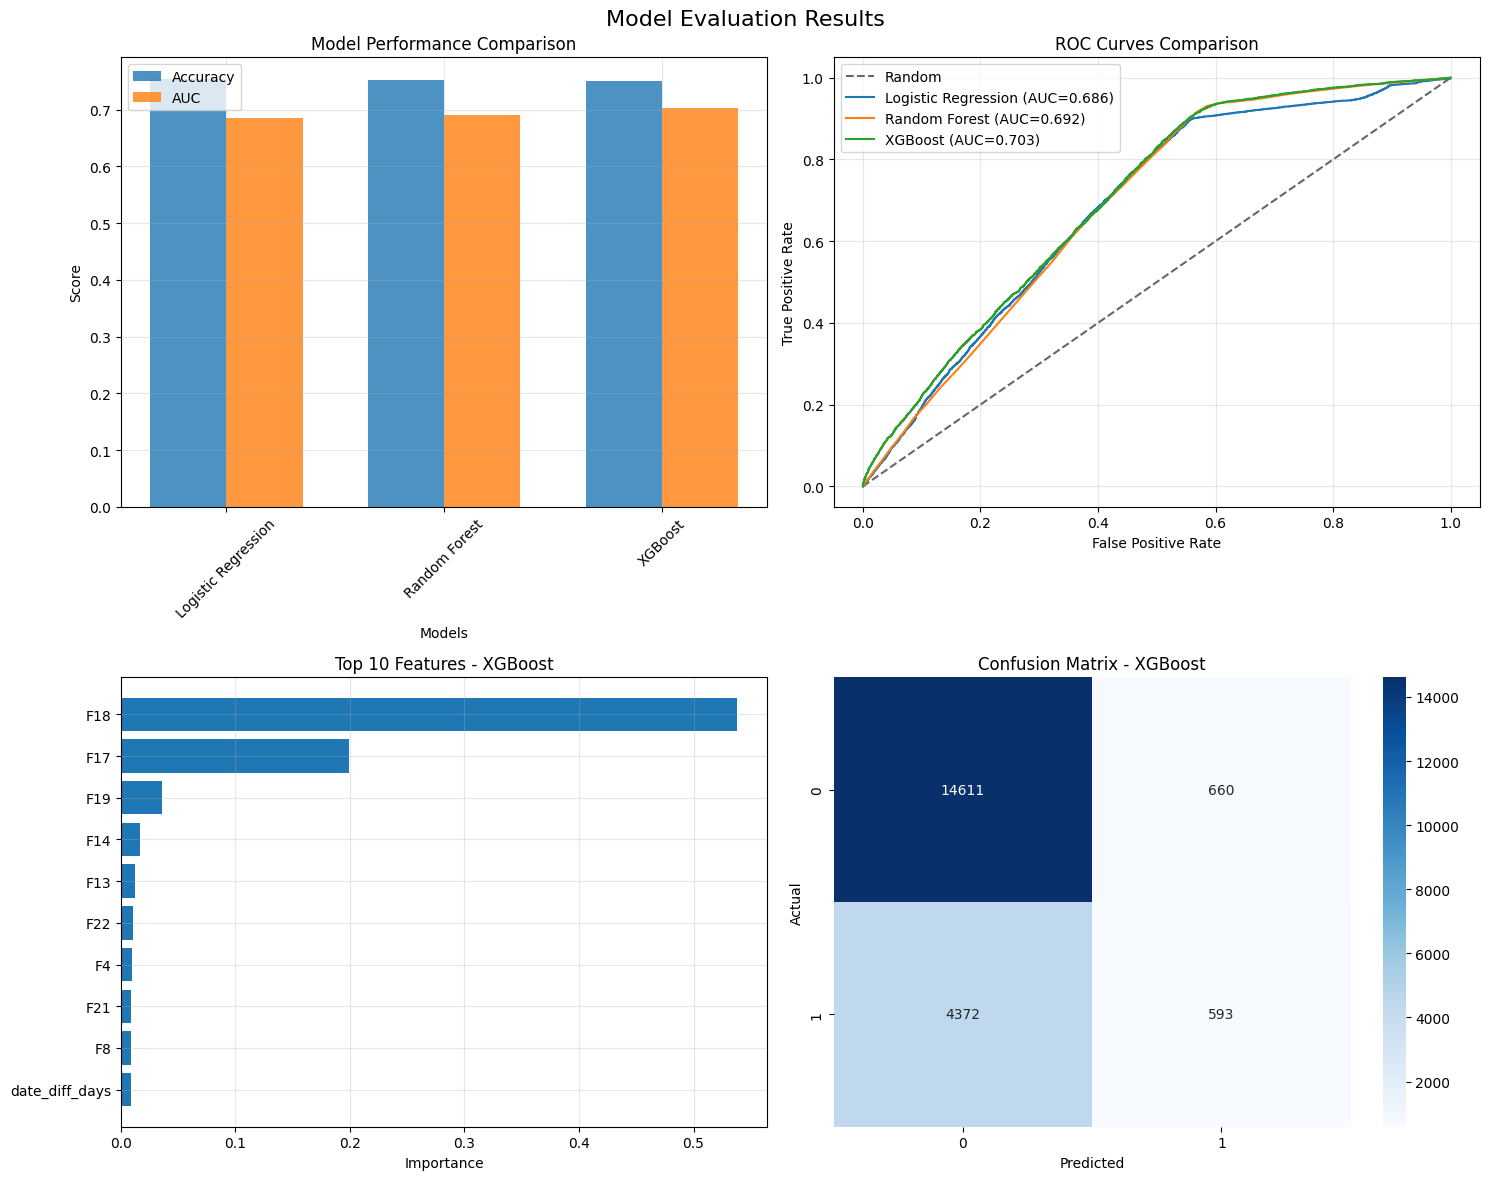


Top 10 Most Important Features (XGBoost):
 1. F18                       : 0.5375
 2. F17                       : 0.1992
 3. F19                       : 0.0360
 4. F14                       : 0.0171
 5. F13                       : 0.0119
 6. F22                       : 0.0105
 7. F4                        : 0.0095
 8. F21                       : 0.0092
 9. F8                        : 0.0090
10. date_diff_days            : 0.0088


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Evaluation Results', fontsize=16)

# 1. Model performance comparison
model_names = list(models.keys())
accuracies = [models[name]['accuracy'] for name in model_names]
aucs = [models[name]['auc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[0, 0].bar(x + width/2, aucs, width, label='AUC', alpha=0.8)
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ROC Curves
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random')

for model_name, model_info in models.items():
    fpr, tpr, _ = roc_curve(y_val, model_info['probabilities'])
    axes[0, 1].plot(fpr, tpr, label=f"{model_name} (AUC={model_info['auc']:.3f})")

axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance (if available)
if 'feature_importance' in best_model:
    importance = best_model['feature_importance']
    indices = np.argsort(importance)[-10:]  # Top 10 features
    
    axes[1, 0].barh(range(len(indices)), importance[indices])
    axes[1, 0].set_yticks(range(len(indices)))
    axes[1, 0].set_yticklabels([feature_columns[i] for i in indices])
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title(f'Top 10 Features - {best_model_name}')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Confusion matrix heatmap
cm = confusion_matrix(y_val, best_model['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}')

plt.tight_layout()
plt.show()

# Print feature importance details
if 'feature_importance' in best_model:
    print(f"\nTop 10 Most Important Features ({best_model_name}):")
    importance = best_model['feature_importance']
    indices = np.argsort(importance)[-10:]
    
    for i, idx in enumerate(reversed(indices)):
        print(f"{i+1:2d}. {feature_columns[idx]:<25} : {importance[idx]:.4f}")

In [7]:
# Prepare test features
X_test = test_processed[feature_columns]

# Make predictions based on best model
if best_model['scaled']:
    # For models that need scaling (like Logistic Regression)
    X_test_processed = scaler.transform(X_test)
    test_predictions = best_model['model'].predict(X_test_processed)
    
    # Also get training predictions with proper scaling
    X_train_full_scaled = scaler.fit_transform(X)
    train_predictions = best_model['model'].predict(X_train_full_scaled)
else:
    # For tree-based models that don't need scaling
    test_predictions = best_model['model'].predict(X_test)
    train_predictions = best_model['model'].predict(X)

print(f"Training predictions distribution: {np.bincount(train_predictions)}")
print(f"Test predictions distribution: {np.bincount(test_predictions)}")
print(f"Training accuracy: {accuracy_score(y, train_predictions):.4f}")

Training predictions distribution: [93166  8014]
Test predictions distribution: [18704  1209]
Training accuracy: 0.8085


In [8]:
# 1. Training predictions (Index + Class)
train_indices = train_data['Index'].values
train_pred_df = pd.DataFrame({
    'Index': train_indices,
    'Class': train_predictions
})

# Save training predictions
train_pred_df.to_csv('training_predictions.txt', sep='\t', index=False)
print("Training predictions saved to 'training_predictions.txt'")
print("Sample training predictions:")
print(train_pred_df.head(10))

# 2. Test predictions (Index + Class)  
test_indices = test_data['Index'].values
test_pred_df = pd.DataFrame({
    'Index': test_indices,
    'Class': test_predictions
})

# Save test predictions
test_pred_df.to_csv('test_predictions.txt', sep='\t', index=False)
print("\nTest predictions saved to 'test_predictions.txt'")
print("Sample test predictions:")
print(test_pred_df.head(10))

# Verify file format
print("\nVerifying file formats...")
print("Training predictions file format:")
with open('training_predictions.txt', 'r') as f:
    for i, line in enumerate(f):
        print(f"Line {i+1}: {line.strip()}")
        if i >= 2:  # Show first 3 lines
            break

print("\nTest predictions file format:")
with open('test_predictions.txt', 'r') as f:
    for i, line in enumerate(f):
        print(f"Line {i+1}: {line.strip()}")
        if i >= 2:  # Show first 3 lines
            break

Training predictions saved to 'training_predictions.txt'
Sample training predictions:
   Index  Class
0      1      0
1      2      0
2      3      0
3      4      0
4      5      0
5      6      0
6      7      0
7      8      0
8      9      0
9     10      0

Test predictions saved to 'test_predictions.txt'
Sample test predictions:
       Index  Class
0  T30234341      1
1  T30234342      0
2  T30234343      0
3  T30234344      0
4  T30234345      0
5  T30234346      0
6  T30234347      0
7  T30234348      0
8  T30234349      0
9  T30234350      0

Verifying file formats...
Training predictions file format:
Line 1: Index	Class
Line 2: 1	0
Line 3: 2	0

Test predictions file format:
Line 1: Index	Class
Line 2: T30234341	1
Line 3: T30234342	0
